In [ ]:
# default_exp data.transforms

# Time Series Data Augmentation

> Functions used to transform TSTensors (Data Augmentation).

In [ ]:
#export
from tsai.imports import *
from fastai.vision.augment import RandTransform
from tsai.utils import *
from tsai.data.external import *
from tsai.data.core import *
from tsai.data.preprocessing import *

In [ ]:
#export
from scipy.interpolate import CubicSpline
from scipy.ndimage import convolve1d, zoom
import pywt
from pyts.image.gaf import GramianAngularField

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, return_split=False)
tfms = [None, Categorize()]
batch_tfms = TSStandardize()
dls = get_ts_dls(X, y, tfms=tfms, splits=splits, batch_tfms=batch_tfms, bs=128)
xb, yb = next(iter(dls.train))

In [ ]:
#export
class TSIdentity(RandTransform):
    "Applies the identity tfm to a `TSTensor` batch"
    order = 90
    def __init__(self, magnitude=None, **kwargs): 
        self.magnitude = magnitude 
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor): return o

In [ ]:
test_eq(TSIdentity()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
# partial(TSShuffle_HLs, ex=0), 
class TSShuffle_HLs(RandTransform):
    "Randomly shuffles HIs/LOs of an OHLC `TSTensor` batch"
    order = 90
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        timesteps = o.shape[-1] // 4
        pos_rand_list = np.random.choice(np.arange(timesteps),size=random.randint(1, timesteps),replace=False)
        rand_list = pos_rand_list * 4
        highs = rand_list + 1
        lows = highs + 1
        a = np.vstack([highs, lows]).flatten('F')
        b = np.vstack([lows, highs]).flatten('F')
        output = o.clone()
        output[...,a] = output[...,b]
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSShuffle_HLs()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
# partial(TSShuffleSteps, ex=0), 
class TSShuffleSteps(RandTransform):
    "Randomly shuffles consecutive sequence datapoints in batch"
    order = 90
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        odd = 1 - o.shape[-1]%2
        r = np.random.randint(2)
        timesteps = o.shape[-1] // 2
        pos_rand_list = np.random.choice(np.arange(0, timesteps - r * odd), size=random.randint(1, timesteps - r * odd),replace=False) * 2 + 1 + r
        a = np.vstack([pos_rand_list, pos_rand_list - 1]).flatten('F')
        b = np.vstack([pos_rand_list - 1, pos_rand_list]).flatten('F')
        output = o.clone()
        output[...,a] = output[...,b]
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

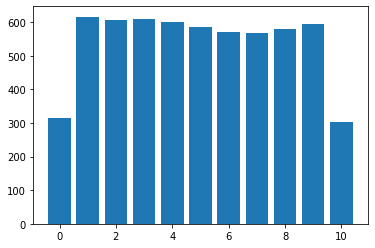

In [ ]:
t = TSTensor(torch.arange(11).float())
tt_ = []
for _ in range(1000): 
    tt = TSShuffleSteps()(t, split_idx=0)
    test_eq(len(set(tt.tolist())), len(t))
    test_ne(tt, t)
    tt_.extend([t for i,t in enumerate(tt) if t!=i])
x, y = np.unique(tt_, return_counts=True) # This is to visualize distribution which should be equal for all and half for first and last items
plt.bar(x, y);

In [ ]:
#export
class TSMagAddNoise(RandTransform):
    "Applies additive noise on the y-axis for each step of a `TSTensor` batch"
    order = 90
    def __init__(self, magnitude=1, ex=None, **kwargs):
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        # output = o + torch.normal(0, o.std() * self.magnitude, o.shape, dtype=o.dtype, device=o.device)
        output = o + torch.normal(0, 1/3, o.shape, dtype=o.dtype, device=o.device) * (o[..., 1:] - o[..., :-1]).std(2, keepdims=True) * self.magnitude
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

class TSMagMulNoise(RandTransform): 
    "Applies multiplicative noise on the y-axis for each step of a `TSTensor` batch"
    order = 90
    def __init__(self, magnitude=1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        noise = torch.normal(1, self.magnitude * .025, o.shape, dtype=o.dtype, device=o.device)
        output = o * noise
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSMagAddNoise()(xb, split_idx=0).shape, xb.shape)
test_eq(TSMagMulNoise()(xb, split_idx=0).shape, xb.shape)
test_ne(TSMagAddNoise()(xb, split_idx=0), xb)
test_ne(TSMagMulNoise()(xb, split_idx=0), xb)

In [ ]:
#export
def random_curve_generator(o, magnitude=0.1, order=4, noise=None):
    seq_len = o.shape[-1]
    f = CubicSpline(np.linspace(-seq_len, 2 * seq_len - 1, 3 * (order - 1) + 1, dtype=int), 
                    np.random.normal(loc=1.0, scale=magnitude, size=3 * (order - 1) + 1), axis=-1)
    return f(np.arange(seq_len))

def random_cum_curve_generator(o, magnitude=0.1, order=4, noise=None):
    x = random_curve_generator(o, magnitude=magnitude, order=order, noise=noise).cumsum()
    x -= x[0]
    x /= x[-1]
    x = np.clip(x, 0, 1)
    return x * (o.shape[-1] - 1)

def random_cum_noise_generator(o, magnitude=0.1, noise=None):
    seq_len = o.shape[-1]
    x = np.clip(np.ones(seq_len) + np.random.normal(loc=0, scale=magnitude, size=seq_len), 0, 1000).cumsum()
    x -= x[0]
    x /= x[-1]
    return x * (o.shape[-1] - 1)

def random_cum_linear_generator(o, magnitude=0.1):
    seq_len = o.shape[-1]
    win_len = int(round(seq_len * np.random.rand() * magnitude))
    if win_len == seq_len: return np.arange(o.shape[-1])
    start = np.random.randint(0, seq_len - win_len)
    # mult between .5 and 2
    rand = np.random.rand()
    mult = 1 + rand
    if np.random.randint(2): mult = 1 - rand/2
    x = np.ones(seq_len)
    x[start : start + win_len] = mult
    x = x.cumsum()
    x -= x[0]
    x /= x[-1]
    return np.clip(x, 0, 1) * (seq_len - 1)

In [ ]:
#export
class TSTimeNoise(RandTransform):
    "Applies noise to each step in the x-axis of a `TSTensor` batch based on smooth random curve"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        f = CubicSpline(np.arange(o.shape[-1]), o.cpu(), axis=-1)
        output = o.new(f(random_cum_noise_generator(o, magnitude=self.magnitude)))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSTimeNoise()(xb, split_idx=0).shape, xb.shape)
test_ne(TSTimeNoise()(xb, split_idx=0), xb)

In [ ]:
#export
class TSMagWarp(RandTransform):
    "Applies warping to the y-axis of a `TSTensor` batch based on a smooth random curve"
    order = 90
    def __init__(self, magnitude=0.02, ord=4, ex=None, **kwargs): 
        self.magnitude, self.ord, self.ex = magnitude, ord, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if self.magnitude and self.magnitude <= 0: return o
        y_mult = random_curve_generator(o, magnitude=self.magnitude, order=self.ord)
        output = o * o.new(y_mult)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSMagWarp()(xb, split_idx=0).shape, xb.shape)
test_ne(TSMagWarp()(xb, split_idx=0), xb)

In [ ]:
#export
class TSTimeWarp(RandTransform):
    "Applies time warping to the x-axis of a `TSTensor` batch based on a smooth random curve"
    order = 90
    def __init__(self, magnitude=0.02, ord=4, ex=None, **kwargs): 
        self.magnitude, self.ord, self.ex = magnitude, ord, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        f = CubicSpline(np.arange(o.shape[-1]), o.cpu(), axis=-1)
        output = o.new(f(random_cum_curve_generator(o, magnitude=self.magnitude, order=self.ord)))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSTimeWarp()(xb, split_idx=0).shape, xb.shape)
test_ne(TSTimeWarp()(xb, split_idx=0), xb)

In [ ]:
#export
class TSWindowWarp(RandTransform):
    """Applies window slicing to the x-axis of a `TSTensor` batch based on a random linear curve based on
    https://halshs.archives-ouvertes.fr/halshs-01357973/document"""
    order = 90
    def __init__(self, magnitude=0.1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        f = CubicSpline(np.arange(o.shape[-1]), o.cpu(), axis=-1)
        output = o.new(f(random_cum_linear_generator(o, magnitude=self.magnitude)))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSWindowWarp()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSMagScale(RandTransform):
    "Applies scaling to the y-axis of a `TSTensor` batch based on a scalar"
    order = 90
    def __init__(self, magnitude=0.5, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        rand = random_half_normal()
        scale = (1 - (rand  * self.magnitude)/2) if random.random() > 1/3 else (1 + (rand  * self.magnitude))
        output = o * scale
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
    
class TSMagScalePerVar(RandTransform):
    "Applies per_var scaling to the y-axis of a `TSTensor` batch based on a scalar"
    order = 90
    def __init__(self, magnitude=0.5, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        s = [1] * o.ndim
        s[-2] = o.shape[-2]
        rand = random_half_normal_tensor(s, device=o.device)
        scale = (1 - (rand  * self.magnitude)/2) if random.random() > 1/3 else (1 + (rand  * self.magnitude))
        output = o * scale
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
    
TSMagScaleByVar = TSMagScalePerVar

In [ ]:
test_eq(TSMagScale()(xb, split_idx=0).shape, xb.shape)
test_eq(TSMagScalePerVar()(xb, split_idx=0).shape, xb.shape)
test_ne(TSMagScale()(xb, split_idx=0), xb)
test_ne(TSMagScalePerVar()(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomResizedCrop(RandTransform):
    "Randomly amplifies a sequence focusing on a random section of the steps"
    order = 90
    def __init__(self, magnitude=0.1, size=None, scale=None, ex=None, mode='linear', **kwargs): 
        """
        Args:
            size: None, int or float
            scale: None or tuple of 2 floats 0 < float <= 1
            mode:  'nearest' | 'linear' | 'area'
        
        """
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        if scale is not None: 
            assert is_listy(scale) and len(scale) == 2 and min(scale) > 0 and min(scale) <= 1, "scale must be a tuple with 2 floats 0 < float <= 1"
        self.size,self.scale = size,scale
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        if self.size is not None: 
            size = self.size if isinstance(self.size, Integral) else int(round(self.size * seq_len))
        else:
            size = seq_len
        if self.scale is not None: 
            lambd = np.random.uniform(self.scale[0], self.scale[1])
        else: 
            lambd = np.random.beta(self.magnitude, self.magnitude)
            lambd = max(lambd, 1 - lambd)
        win_len = int(round(seq_len * lambd))
        if win_len == seq_len: 
            if size == seq_len: return o
            _slice = slice(None) 
        else:
            start = np.random.randint(0, seq_len - win_len)
            _slice = slice(start, start + win_len)
        return F.interpolate(o[..., _slice], size=size, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
    
TSRandomZoomIn = TSRandomResizedCrop

In [ ]:
test_eq(TSRandomResizedCrop(.5)(xb, split_idx=0).shape, xb.shape)
test_ne(TSRandomResizedCrop(size=.8, scale=(.5, 1))(xb, split_idx=0).shape, xb.shape)
test_ne(TSRandomResizedCrop(size=20, scale=(.5, 1))(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSWindowSlicing(RandTransform):
    "Randomly extracts an resize a ts slice based on https://halshs.archives-ouvertes.fr/halshs-01357973/document"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        seq_len = o.shape[-1]
        win_len = int(round(seq_len * (1 - self.magnitude)))
        if win_len == seq_len: return o
        start = np.random.randint(0, seq_len - win_len)
        return F.interpolate(o[..., start : start + win_len], size=seq_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

In [ ]:
test_eq(TSWindowSlicing()(xb, split_idx=0).shape, xb.shape)
test_ne(TSWindowSlicing()(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomZoomOut(RandTransform):
    "Randomly compresses a sequence on the x-axis"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = max(lambd, 1 - lambd)
        win_len = int(round(seq_len * lambd))
        if win_len == seq_len: return o
        start = (seq_len - win_len) // 2
        output = torch.zeros_like(o, dtype=o.dtype, device=o.device)
        interp = F.interpolate(o, size=win_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        output[..., start:start + win_len] = o.new(interp)
        return output

In [ ]:
test_eq(TSRandomZoomOut(.5)(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomTimeScale(RandTransform):
    "Randomly amplifies/ compresses a sequence on the x-axis keeping the same length"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        if np.random.rand() <= 0.5: return TSRandomZoomIn(magnitude=self.magnitude, ex=self.ex, mode=self.mode)(o, split_idx=0)
        else: return TSRandomZoomOut(magnitude=self.magnitude, ex=self.ex, mode=self.mode)(o, split_idx=0)

In [ ]:
test_eq(TSRandomTimeScale(.5)(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomTimeStep(RandTransform):
    "Compresses a sequence on the x-axis by randomly selecting sequence steps and interpolating to previous size"
    order = 90
    def __init__(self, magnitude=0.02, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        new_seq_len = int(round(seq_len * max(.5, (1 - np.random.rand() * self.magnitude))))
        if  new_seq_len == seq_len: return o
        timesteps = np.sort(np.random.choice(np.arange(seq_len),new_seq_len, replace=False))
        output = F.interpolate(o[..., timesteps], size=seq_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomTimeStep()(xb, split_idx=0).shape, xb.shape)

In [ ]:
# export

class TSResampleSteps(RandTransform):
    "Transform that randomly selects and sorts sequence steps (with replacement) maintaining the sequence length"

    order = 90
    def __init__(self, step_pct=1., same_seq_len=True, magnitude=None, **kwargs):
        assert step_pct > 0, 'seq_len_pct must be subsample > 0'
        self.step_pct, self.same_seq_len = step_pct, same_seq_len
        super().__init__(**kwargs)

    def encodes(self, o: TSTensor):
        S = o.shape[-1]
        if isinstance(self.step_pct, tuple):
            step_pct = np.random.rand() * (self.step_pct[1] - self.step_pct[0]) + self.step_pct[0]
        else: 
            step_pct = self.step_pct
        if step_pct != 1 and self.same_seq_len:
            idxs = np.sort(np.tile(np.random.choice(S, round(S * step_pct), True), math.ceil(1 / step_pct))[:S])
        else:
            idxs = np.sort(np.random.choice(S, round(S * step_pct), True))
        return o[..., idxs]
    
TSSubsampleSteps = TSResampleSteps

In [ ]:
test_eq(TSResampleSteps(step_pct=.9, same_seq_len=False)(xb, split_idx=0).shape[-1], round(.9*xb.shape[-1]))
test_eq(TSResampleSteps(step_pct=.9, same_seq_len=True)(xb, split_idx=0).shape[-1], xb.shape[-1])

In [ ]:
#export
class TSBlur(RandTransform):
    "Blurs a sequence applying a filter of type [1, 0, 1]"
    order = 90
    def __init__(self, magnitude=1., ex=None, filt_len=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        if filt_len is None: 
            filterargs = [1, 0, 1]  
        else: 
            filterargs = ([1] * max(1, filt_len // 2) + [0] + [1] * max(1, filt_len // 2))
        self.filterargs = np.array(filterargs) 
        self.filterargs = self.filterargs/self.filterargs.sum()
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        output = o.new(convolve1d(o.cpu(), self.filterargs, mode='nearest'))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSBlur(filt_len=7)(xb, split_idx=0).shape, xb.shape)
test_ne(TSBlur()(xb, split_idx=0), xb)

In [ ]:
#export
class TSSmooth(RandTransform):
    "Smoothens a sequence applying a filter of type [1, 5, 1]"
    order = 90
    def __init__(self, magnitude=1., ex=None, filt_len=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        self.filterargs = np.array([1, 5, 1])
        if filt_len is None: 
            filterargs = [1, 5, 1]  
        else: 
            filterargs = ([1] * max(1, filt_len // 2) + [5] + [1] * max(1, filt_len // 2))
        self.filterargs = np.array(filterargs) 
        self.filterargs = self.filterargs/self.filterargs.sum()
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        output = o.new(convolve1d(o.cpu(), self.filterargs, mode='nearest'))
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSSmooth(filt_len=7)(xb, split_idx=0).shape, xb.shape)
test_ne(TSSmooth()(xb, split_idx=0), xb)

In [ ]:
#export
def maddest(d, axis=None): #Mean Absolute Deviation
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

class TSFreqDenoise(RandTransform):
    "Denoises a sequence applying a wavelet decomposition method"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, wavelet='db4', level=2, thr=None, thr_mode='hard', pad_mode='per', **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        self.wavelet, self.level, self.thr, self.thr_mode, self.pad_mode = wavelet, level, thr, thr_mode, pad_mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        """
        1. Adapted from waveletSmooth function found here:
        http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
        2. Threshold equation and using hard mode in threshold as mentioned
        in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
        http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
        """
        seq_len = o.shape[-1]
        # Decompose to get the wavelet coefficients
        coeff = pywt.wavedec(o.cpu(), self.wavelet, mode=self.pad_mode)
        # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
        # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
        sigma = (1/0.6745) * maddest(coeff[-self.level])
        # Calculate the univeral threshold
        uthr = sigma * np.sqrt(2*np.log(seq_len)) * (1 if self.thr is None else self.magnitude)
        coeff[1:] = (pywt.threshold(c, value=uthr, mode=self.thr_mode) for c in coeff[1:])
        # Reconstruct the signal using the thresholded coefficients
        output = o.new(pywt.waverec(coeff, self.wavelet, mode=self.pad_mode)[..., :seq_len])
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSFreqDenoise()(xb, split_idx=0).shape, xb.shape)
test_ne(TSFreqDenoise()(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomFreqNoise(RandTransform):
    "Applys random noise using a wavelet decomposition method"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, wavelet='db4', level=2, mode='constant', **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        self.wavelet, self.level, self.mode = wavelet, level, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        self.level = 1 if self.level is None else self.level
        coeff = pywt.wavedec(o.cpu(), self.wavelet, mode=self.mode, level=self.level)
        coeff[1:] = [c * (1 + 2 * (np.random.rand() - 0.5) * self.magnitude) for c in coeff[1:]]
        output = o.new(pywt.waverec(coeff, self.wavelet, mode=self.mode)[..., :o.shape[-1]])
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomFreqNoise()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomResizedLookBack(RandTransform):
    "Selects a random number of sequence steps starting from the end and return an output of the same shape"
    order = 90
    def __init__(self, magnitude=0.1, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.mode = magnitude, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = min(lambd, 1 - lambd)
        output = o.clone()[..., int(round(lambd * seq_len)):]
        return F.interpolate(output, size=seq_len, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

In [ ]:
for i in range(100): 
    o = TSRandomResizedLookBack()(xb, split_idx=0)
    test_eq(o.shape[-1], xb.shape[-1])

In [ ]:
#export
class TSRandomLookBackOut(RandTransform):
    "Selects a random number of sequence steps starting from the end and set them to zero"
    order = 90
    def __init__(self, magnitude=0.1, **kwargs): 
        self.magnitude = magnitude
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = min(lambd, 1 - lambd)
        output = o.clone()
        output[..., :int(round(lambd * seq_len))] = 0 
        return output

In [ ]:
for i in range(100): 
    o = TSRandomLookBackOut()(xb, split_idx=0)
    test_eq(o.shape[-1], xb.shape[-1])

In [ ]:
#export
class TSVarOut(RandTransform):
    "Set the value of a random number of variables to zero"
    order = 90
    def __init__(self, magnitude=0.05, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        in_vars = o.shape[-2]
        if in_vars == 1: return o
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = min(lambd, 1 - lambd)
        p = np.arange(in_vars).cumsum()
        p = p/p[-1]
        p = p / p.sum()
        p = p[::-1]
        out_vars = np.random.choice(np.arange(in_vars), int(round(lambd * in_vars)), p=p, replace=False)
        if len(out_vars) == 0:  return o
        output = o.clone()
        output[...,out_vars,:] = 0
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSVarOut()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSCutOut(RandTransform):
    "Sets a random section of the sequence to zero"
    order = 90
    def __init__(self, magnitude=0.05, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = min(lambd, 1 - lambd)
        win_len = int(round(seq_len * lambd))
        start = np.random.randint(-win_len + 1, seq_len)
        end = start + win_len
        start = max(0, start)
        end = min(end, seq_len)
        output = o.clone()
        output[..., start:end] = 0
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSCutOut()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSTimeStepOut(RandTransform):
    "Sets random sequence steps to zero"
    order = 90
    def __init__(self, magnitude=0.05, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        magnitude = min(.5, self.magnitude)
        seq_len = o.shape[-1]
        timesteps = np.sort(np.random.choice(np.arange(seq_len), int(round(seq_len * magnitude)), replace=False))
        output = o.clone()
        output[..., timesteps] = 0
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSTimeStepOut()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomCropPad(RandTransform):
    "Crops a section of the sequence of a random length"
    order = 90
    def __init__(self, magnitude=0.05, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = max(lambd, 1 - lambd)
        win_len = int(round(seq_len * lambd))
        if win_len == seq_len: return o
        start = np.random.randint(0, seq_len - win_len)
        output = torch.zeros_like(o, dtype=o.dtype, device=o.device)
        output[..., start : start + win_len] = o[..., start : start + win_len]
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomCropPad()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export

from tsai.callback.MVP import create_mask

class TSMaskOut(RandTransform):
    """Applies a random mask"""
    order = 90
    def __init__(self, magnitude=0.1, lm:int=3, stateful:bool=True, sync:bool=False, subsequence_mask:bool=True, 
                 variable_mask:bool=False, future_mask:bool=False, schedule_func:Optional[callable]=None, compensate:bool=False, ex=None, **kwargs):
        store_attr()
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        r = self.magnitude * self.schedule_func(self.pct_train) if self.schedule_func is not None else self.magnitude
        mask = create_mask(o,  r=r, lm=self.lm, stateful=self.stateful, sync=self.sync, 
                           subsequence_mask=self.subsequence_mask, variable_mask=self.variable_mask, future_mask=self.future_mask)
        if self.compensate: # per sample and feature
            mean_per_seq = (torch.max(torch.ones(1, device=mask.device), torch.sum(mask, dim=-1).unsqueeze(-1)) / mask.shape[-1])
            output = o.masked_fill(mask, 0) / (1 - mean_per_seq)
        else:
            output = o.masked_fill(mask, 0)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSMaskOut()(xb, split_idx=0).shape, xb.shape)
test_ne(TSMaskOut()(xb, split_idx=0), xb)

In [ ]:
# export

class TSInputDropout(RandTransform):
    """Applies input dropout with required_grad=False"""
    order = 90
    def __init__(self, magnitude=0., ex=None, **kwargs):
        self.magnitude, self.ex = magnitude, ex
        self.dropout = nn.Dropout(magnitude)
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        with torch.no_grad(): output = self.dropout(o)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSInputDropout(.1)(xb, split_idx=0).shape, xb.shape)
test_ne(TSInputDropout(.1)(xb, split_idx=0), xb)

In [ ]:
#export
class TSTranslateX(RandTransform):
    "Moves a selected sequence window a random number of steps"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        seq_len = o.shape[-1]
        lambd = np.random.beta(self.magnitude, self.magnitude)
        lambd = min(lambd, 1 - lambd)
        shift = int(round(seq_len * lambd))
        if shift == 0 or shift == seq_len: return o
        if np.random.rand() < 0.5: shift = -shift
        new_start = max(0, shift)
        new_end = min(seq_len + shift, seq_len)
        start = max(0, -shift)
        end = min(seq_len - shift, seq_len)
        output = torch.zeros_like(o, dtype=o.dtype, device=o.device)
        output[..., new_start : new_end] = o[..., start : end]
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSTranslateX()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomShift(RandTransform):
    "Shifts and splits a sequence"
    order = 90
    def __init__(self, magnitude=0.02, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        pos = int(round(np.random.randint(0, o.shape[-1]) * self.magnitude)) * (random.randint(0, 1)*2-1)
        output = torch.cat((o[..., pos:], o[..., :pos]), dim=-1)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomShift()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSHorizontalFlip(RandTransform):
    "Flips the sequence along the x-axis"
    order = 90
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        output = torch.flip(o, [-1])
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSHorizontalFlip()(xb, split_idx=0).shape, xb.shape)
test_ne(TSHorizontalFlip()(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomTrend(RandTransform):
    "Randomly rotates the sequence along the z-axis"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        flat_x = o.reshape(o.shape[0], -1)
        ran = flat_x.max(dim=-1, keepdim=True)[0] - flat_x.min(dim=-1, keepdim=True)[0]
        trend = torch.linspace(0, 1, o.shape[-1], device=o.device) * ran
        t = (1 + self.magnitude * 2 * (np.random.rand() - 0.5) * trend)
        t -= t.mean(-1, keepdim=True)
        if o.ndim == 3: t = t.unsqueeze(1)
        output = o + t
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output
    
TSRandomRotate = TSRandomTrend

In [ ]:
test_eq(TSRandomTrend()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSVerticalFlip(RandTransform):
    "Applies a negative value to the time sequence"
    order = 90
    def __init__(self, magnitude=1., ex=None, **kwargs): 
        self.magnitude, self.ex = magnitude, ex
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor): 
        if not self.magnitude or self.magnitude <= 0: return o
        return - o

In [ ]:
test_eq(TSVerticalFlip()(xb, split_idx=0).shape, xb.shape)
test_ne(TSVerticalFlip()(xb, split_idx=0), xb)

In [ ]:
#export
class TSResize(RandTransform):
    "Resizes the sequence length of a time series"
    order = 90
    def __init__(self, magnitude=-0.5, size=None, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.size, self.ex, self.mode = magnitude, size, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor): 
        if self.magnitude == 0: return o
        size = ifnone(self.size, int(round((1 + self.magnitude) * o.shape[-1])))
        output = F.interpolate(o, size=size, mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        return output

In [ ]:
for sz in np.linspace(.2, 2, 10): test_eq(TSResize(sz)(xb, split_idx=0).shape[-1], int(round(xb.shape[-1]*(1+sz))))
test_ne(TSResize(1)(xb, split_idx=0), xb)

In [ ]:
#export
class TSRandomSize(RandTransform):
    "Randomly resizes the sequence length of a time series"
    order = 90
    def __init__(self, magnitude=0.1, ex=None, mode='linear', **kwargs):
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        size_perc = 1 + random_half_normal() * self.magnitude * (-1 if random.random() > .5 else 1)
        return F.interpolate(o, size=int(size_perc * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

In [ ]:
seq_len_ = []
for i in range(100): 
    o = TSRandomSize(.5)(xb, split_idx=0)
    seq_len_.append(o.shape[-1])
test_lt(min(seq_len_), xb.shape[-1])
test_gt(max(seq_len_), xb.shape[-1])

In [ ]:
#export
class TSRandomLowRes(RandTransform):
    "Randomly resizes the sequence length of a time series to a lower resolution"
    order = 90
    def __init__(self, magnitude=.5, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor): 
        if not self.magnitude or self.magnitude <= 0: return o
        size_perc = 1 - (np.random.rand() * (1 - self.magnitude))
        return F.interpolate(o, size=int(size_perc * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)

In [ ]:
#export
class TSDownUpScale(RandTransform):
    "Downscales a time series and upscales it again to previous sequence length"
    order = 90
    def __init__(self, magnitude=0.5, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor): 
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        output = F.interpolate(o, size=int((1 - self.magnitude) * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        output = F.interpolate(output, size=o.shape[-1], mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSDownUpScale()(xb, split_idx=0).shape, xb.shape)

In [ ]:
#export
class TSRandomDownUpScale(RandTransform):
    "Randomly downscales a time series and upscales it again to previous sequence length"
    order = 90
    def __init__(self, magnitude=.5, ex=None, mode='linear', **kwargs): 
        "mode:  'nearest' | 'linear' | 'area'"
        self.magnitude, self.ex, self.mode = magnitude, ex, mode
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor): 
        if not self.magnitude or self.magnitude <= 0 or self.magnitude >= 1: return o
        scale_factor = 0.5 + 0.5 * np.random.rand() 
        output = F.interpolate(o, size=int(scale_factor * o.shape[-1]), mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        output = F.interpolate(output, size=o.shape[-1], mode=self.mode, align_corners=None if self.mode in ['nearest', 'area'] else False)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
test_eq(TSRandomDownUpScale()(xb, split_idx=0).shape, xb.shape)
test_ne(TSDownUpScale()(xb, split_idx=0), xb)
test_eq(TSDownUpScale()(xb, split_idx=1), xb)

In [ ]:
#export
class TSRandomConv(RandTransform):
    """Applies a convolution with a random kernel and random weights with required_grad=False"""
    order = 90
    def __init__(self, magnitude=0.05, ex=None, ks=[1, 3, 5, 7], **kwargs):
        self.magnitude, self.ex, self.ks = magnitude, ex, ks
        self.conv = nn.Conv1d(1, 1, 1, bias=False)
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        if not self.magnitude or self.magnitude <= 0 or self.ks is None: return o
        ks = np.random.choice(self.ks, 1)[0] if is_listy(self.ks) else self.ks
        c_in = o.shape[1]
        weight = nn.Parameter(torch.zeros(c_in, c_in, ks, device=o.device, requires_grad=False))
        nn.init.kaiming_normal_(weight)
        self.conv.weight = weight
        self.conv.padding = ks // 2
        output = (1 - self.magnitude) * o + self.magnitude * self.conv(o)
        if self.ex is not None: output[...,self.ex,:] = o[...,self.ex,:]
        return output

In [ ]:
for i in range(5): 
    o = TSRandomConv(magnitude=0.05, ex=None, ks=[1, 3, 5, 7])(xb, split_idx=0)
    test_eq(o.shape, xb.shape)

In [ ]:
#export
class TSRandomSet2Value(RandTransform):
    "Randomly sets selected variables of type `TSTensor` to predefined value (default: np.nan)"
    order = 90
    def __init__(self, magnitude=0.1, sel_vars=None, static=False, value=np.nan, **kwargs):
        self.sel_vars = sel_vars if sel_vars is not None else None
        self.magnitude, self.static, self.value = magnitude , static, value
        super().__init__(**kwargs)

    def encodes(self, o:TSTensor):
        if not self.magnitude or self.magnitude <= 0: return o
        if self.static:
            vals = torch.rand(*o.shape[:-1])
        else:
            vals = torch.rand(*o.shape)
        if self.sel_vars is not None:
            vals[:, ~np.isin(np.arange(o.shape[1]), self.sel_vars)] = 0
        o[vals > (1 - self.magnitude)] = self.value
        return o

In [ ]:
t = TSTensor(torch.ones(2,3,4))
TSRandomSet2Value(magnitude=.5, sel_vars=[0,2])(t, split_idx=0).data

tensor([[[nan, 1., 1., nan],
         [1., 1., 1., 1.],
         [1., 1., nan, nan]],

        [[1., 1., nan, 1.],
         [1., 1., 1., 1.],
         [1., nan, nan, 1.]]])

In [ ]:
t = TSTensor(torch.ones(2,3,100))
test_gt(np.isnan(TSRandomSet2Value(magnitude=.5)(t, split_idx=0)).sum().item(), 0)
t = TSTensor(torch.ones(2,3,100))
test_gt(np.isnan(TSRandomSet2Value(magnitude=.5, sel_vars=[0,2])(t, split_idx=0)[:, [0,2]]).sum().item(), 0)
t = TSTensor(torch.ones(2,3,100))
test_eq(np.isnan(TSRandomSet2Value(magnitude=.5, sel_vars=[0,2])(t, split_idx=0)[:, 1]).sum().item(), 0)

In [ ]:
#export
all_TS_randaugs = [
    
    TSIdentity, 
    
    # Noise
    (TSMagAddNoise, 0.1, 1.),
    (partial(TSMagMulNoise, ex=0), 0.1, 1),
    (partial(TSTimeNoise, ex=0), 0.1, 1.),
    (partial(TSRandomFreqNoise, ex=0), 0.1, 1.),
    partial(TSShuffleSteps, ex=0),
    (TSRandomTimeScale, 0.05, 0.5), 
    (TSRandomTimeStep, 0.05, 0.5), 
    (partial(TSFreqDenoise, ex=0), 0.1, 1.),
    (TSRandomLowRes, 0.05, 0.5),
    (TSInputDropout, 0.05, .5),
    
    # Magnitude
    (partial(TSMagWarp, ex=0), 0.02, 0.2),
    (TSMagScale, 0.2, 1.),
    (partial(TSMagScalePerVar, ex=0), 0.2, 1.),
    (partial(TSRandomConv, ex=0), .05, .2),
    partial(TSBlur, ex=0),
    partial(TSSmooth, ex=0),
    partial(TSDownUpScale, ex=0),
    partial(TSRandomDownUpScale, ex=0), 
    (TSRandomTrend, 0.1, 0.5), 
    TSVerticalFlip, 
    (TSVarOut, 0.05, 0.5), 
    (TSCutOut, 0.05, 0.5), 
    
    # Time
    (partial(TSTimeWarp, ex=0), 0.02, 0.2),
    (TSWindowWarp, 0.05, 0.5),
    (TSRandomSize, 0.05, 1.),
    TSHorizontalFlip, 
    (TSTranslateX, 0.1, 0.5),
    (TSRandomShift, 0.02, 0.2), 
    (TSRandomZoomIn, 0.05, 0.5), 
    (TSWindowSlicing, 0.05, 0.2),
    (TSRandomZoomOut, 0.05, 0.5),
    (TSRandomLookBackOut, 0.1, 1.),
    (TSRandomResizedLookBack, 0.1, 1.),
    (TSTimeStepOut, 0.01, 0.2),
    (TSRandomCropPad, 0.05, 0.5), 
    (TSRandomResizedCrop, 0.05, 0.5),
    (TSMaskOut, 0.01, 0.2),
]

In [ ]:
#export
class RandAugment(RandTransform):
    order = 90
    def __init__(self, tfms:list, N:int=1, M:int=3, **kwargs):
        '''
        tfms   : list of tfm functions (not called)
        N      : number of tfms applied to each batch (usual values 1-3)
        M      : tfm magnitude multiplier (1-10, usually 3-5). Only works if tfms are tuples (tfm, min, max)
        kwargs : RandTransform kwargs
        '''
        super().__init__(**kwargs)
        if not isinstance(tfms, list): tfms = [tfms]
        self.tfms, self.N, self.magnitude = tfms, min(len(tfms), N), M / 10
        self.n_tfms, self.tfms_idxs = len(tfms), np.arange(len(tfms))

    def encodes(self, o:(NumpyTensor, TSTensor)):
        if not self.N or not self.magnitude: return o
        tfms = self.tfms if self.n_tfms==1 else L(self.tfms)[np.random.choice(np.arange(self.n_tfms), self.N, replace=False)]
        tfms_ = []
        for tfm in tfms:
            if isinstance(tfm, tuple):
                t, min_val, max_val = tfm
                tfms_ += [t(magnitude=self.magnitude * float(max_val - min_val) + min_val)]
            else:  tfms_ += [tfm()]
        output = compose_tfms(o, tfms_, split_idx=self.split_idx)
        return output

In [ ]:
test_ne(RandAugment(TSMagAddNoise, N=5, M=10)(xb, split_idx=0), xb)

In [ ]:
#export
class TestTfm(RandTransform):
    "Utility class to test the output of selected tfms during training"
    def __init__(self, tfm, magnitude=1., ex=None, **kwargs): 
        self.tfm, self.magnitude, self.ex = tfm, magnitude, ex
        self.tfmd, self.shape = [], []
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor): 
        if not self.magnitude or self.magnitude <= 0: return o
        output = self.tfm(o, split_idx=self.split_idx)
        self.tfmd.append(torch.equal(o, output))
        self.shape.append(o.shape)
        return output

In [ ]:
#export
def get_tfm_name(tfm):
    if isinstance(tfm, tuple): tfm = tfm[0]
    if hasattr(tfm, "func"): tfm = tfm.func
    if hasattr(tfm, "__name__"): return tfm.__name__
    elif hasattr(tfm, "__class__") and hasattr(tfm.__class__, "__name__"): return tfm.__class__.__name__
    else: return tfm

In [ ]:
test_eq(get_tfm_name(partial(TSMagScale()))==get_tfm_name((partial(TSMagScale()), 0.1, .05))==get_tfm_name(TSMagScale())==get_tfm_name((TSMagScale(), 0.1, .05)), True)

In [ ]:
all_TS_randaugs_names = [get_tfm_name(t) for t in all_TS_randaugs]

In [ ]:
#hide
from tsai.imports import create_scripts
from tsai.export import get_nb_name
nb_name = get_nb_name()
create_scripts(nb_name);